In [9]:
'''A simple implementation of HMC on the SIR model.'''

'A simple implementation of HMC on the SIR model.'

## Introduction 

The following notebook will detail the implementation of Hamiltonian Monte Carlo for inference of the parameters of a SIR differential equation model. Hamiltonian Monte Carlo is an algorithm that uses principles from Hamiltonian mechanics to significantly improvement sampling from Bayesian posteriors in many problems of applied interest. 

We first import jax, diffrax, and matplotlib. Jax is a autodiff library with very similar syntax to numpy and diffrax implements a number of differential equation solvers in jax. Matplotlib is a plotting library. 

In [10]:
from diffrax import diffeqsolve, ODETerm
from jax.scipy.stats import norm,poisson
import diffrax
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

Here is the model setup. The goal of our inference problem is to determine the Bayesian posterior of the model parameters $\beta$ and $\gamma$ given a noisy dataset of infections. Our system of differential equations describing the dynamics of disease are as follows. 

$$
\begin{aligned}
\frac{dS}{dt} &= -\frac{\beta SI}{N} \\
\frac{dI}{dt} &= \frac{\beta SI}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I
\end{aligned}
$$

In [11]:
'''We define our parameters in the log domain and then exponentiate. This will be useful in HMC. '''
beta = jnp.log(0.3)
gamma = jnp.log(0.1)

'''Integrate for 100 days. '''
t_vec = jnp.linspace(0,100,100)

def SIR(t,y,args):
  '''We define the right hand side of the SIR model. This is the format expected by diffrax.'''

  beta,gamma = args

  beta = jnp.exp(beta)
  gamma = jnp.exp(gamma)

  S,I,R = y
  N = S+I+R

  dS = -beta * S * I/N
  dI = beta * S * I/N - gamma * I
  dR = gamma * I


  return jnp.array([dS,dI,dR])

In [12]:
'''The model integrator. Takes the length of time to integrate, the initial condition, and a parameter vector.'''
def model(ts,y0,par):
  solution = diffrax.diffeqsolve(
            ODETerm(SIR),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            saveat=diffrax.SaveAt(ts=t_vec) #At which points to save the output
        )
  return solution.ys



rng_key = jax.random.PRNGKey(0)
noise_key,rng_key = jax.random.split(rng_key)

'''Simulate model'''
y_true = model(t_vec,jnp.array([100,1.,0]),(beta,gamma))

'''We add some noise to our data to be more realistic. Here we use poisson noise. '''
data_I = jax.random.poisson(noise_key,y_true[:,1] + 0.005)



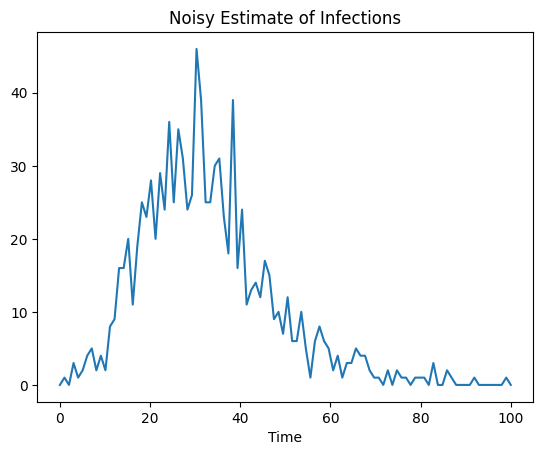

In [13]:
plt.title('Noisy Estimate of Infections')
plt.plot(t_vec,data_I)
plt.xlabel('Time')
plt.show()



### The Likelihood Function

Bayesian inference algorithms such as HMC require a likelihood function. By Bayes theorem,

$$
\begin{aligned}
P(\theta|Y_{1:t}) = \frac{P(Y_{1:t}|\theta)P(\theta)}{P(Y_{1:t})}.
\end{aligned}
$$

where $\theta = [ \beta,\gamma ]^T$ and $Y_{1:t}$ is our data set (the noisy infections). For simplicity we assume $P(\theta)$ is the uniform distribution, therefore  $P(\theta|y) \propto P(y|\theta)$. Our likelihood function is $P(y|\theta)$, the probability that given a certain value of $\theta$ we observe our data. In HMC we use the log of the likelihood. 

Let $\mathcal{M_i}(\theta)$ be the output of our model at time $i$, that is $[S_{i},I_{i},R_{i}]^T = \mathcal{M_i}(\theta)$ and $g(M_i(\theta)) = I_{i}$. Then the likelihood function is

$$
\begin{aligned}
P(Y_{1:t}|\theta) = \prod\limits_{i=1}^{t} P(Y_i|\theta)
\end{aligned}
$$

and $P(Y_i|\theta) = \text{Poisson}(Y_i,g(\mathcal{M_i}(\theta)))$. 


In [14]:
@jax.jit
def log_likelihood(par):
  beta,gamma = par
  model_output = model(t_vec,jnp.array([100.,1.,0.]),(beta,gamma))
  return jnp.sum(poisson.logpmf(data_I, model_output[:,1]))

### Hamiltonian Monte Carlo

The specification of the likelihood function allows us to utilize HMC to sample from $P(\theta|Y_{1:t})$. To do so, for each parameter in $\theta$ we introduce a corresponding momentum. We then have the pair $(\theta_i, r_i)$ for each $\theta_i$ in $\theta$. We then treat this space as a Hamiltonian system. To this end we introduce a scalar function $H(\theta,r) = T(r) + V(\theta)$ called the Hamiltonian. We let $V(\theta)$ be 

$$
\begin{aligned}
V(\theta) = -\log P(Y_{1:t}|\theta)
\end{aligned}
$$

and 

$$
\begin{aligned}
T(p) = \frac{1}{2} r^T M r 
\end{aligned}
$$

where $M$ is a symmetric positive-definite matrix. For simplicity in this example we set $M$ to the identity matrix. In Hamiltonian Monte Carlo we lift up our sampling problem on $P(\theta|Y_{1:t})$ to $P(\theta,r)$ where we define 

$$
\begin{aligned}
P(\theta,r) &\propto e^{-H(\theta,r)}\\ 
&\propto e^{-(T(r) + V(\theta))}\\
&\propto P(\theta|Y_{1:t}) e^{-V(r)}\\
&\propto P(\theta|Y_{1:t}) e^{-\frac{1}{2} r^T M r }. 
\end{aligned}
$$

Note that $P(\theta,r)$ consists of a product of a function of only $\theta$ and a function of only $r$. In addition, the function of $r$ has the functional form of a normal distribution with mean zero and covariance matrix $M^{-1}$. We can see that $P(\theta,r)$ admits $P(\theta|Y_{1:t})$ as a marginal by integrating with respect to $r$

$$
\begin{aligned}
\int_{R^n} P(\theta,r) dr &\propto \int_{R^n} P(\theta|Y_{1:t}) e^{-\frac{1}{2} r^T M r } dr \\
&\propto P(\theta|Y_{1:t}) \int_{R^n} e^{-\frac{1}{2} r^T M r } dr \\
& \propto P(\theta|Y_{1:t})
\end{aligned}
$$

as the integral of the gaussian is finite. 

This suggests we can sample from the joint distribution $P(\theta,r)$ and discard the $r$ samples to obtain samples from $P(\theta|Y_{1:t})$. Sampling a value of $r$ is easy. There are built in algorithms to sample from multivariate normal distributions in jax. Obtaining a sample of $\theta$ requires a little more effort. 

The following description of obtaining our sample of $\theta$ is presented without too much motivation. Details can be found in Michael Betancourt's paper. Due to the Hamiltonian structure we imposed on the joint distribution we can integrate Hamilton's equations along the level sets of $P(\theta,r)$. 

Starting from an initial sample $(\theta^0,r^0)$ we can integrate according to 

$$
\begin{aligned}
\frac{d \theta_i}{dt} &= \frac{\partial H}{\partial r_i} \\
\frac{d r_i}{dt} &=  -\frac{\partial H}{\partial \theta_i}
\end{aligned}
$$

to obtain a new potential sample, $(\theta^{\text{proposal}},r^{\text{proposal}})$.

Ideally, integration according to these equations would ensure $P(\theta^{\text{proposal}},r^{\text{proposal}}) = P(\theta^0,r^0)$ as we traverse the level sets of the joint distribution. However, due to numerical error in solving these differential equations, we may fall off the level set into a region of lower or higher probability. Therefore, we need to perform a Metropolis step to ensure ergodicity of the Markov chain with respect to $P(\theta,r)$. 


In [15]:

def hmc(n_samples, x_init, n_steps, step_size,key):
    """Run Hamiltonian Monte Carlo to draw `n_samples` from the log density
    `logp`, starting at initial state `x0`.
    """
    r_scale = 1
    M = (r_scale**2) * jnp.eye(x_init.shape[0])

    # Kinetic and potential energy functions.
    T = lambda r: 1/2 * (r.T @ M @ r)
    V = lambda x: -log_likelihood(x)

    grad_V = jax.jit(jax.grad(V))

    acc_record = jnp.zeros((n_samples,))

    dim = len(x_init)
    samples = jnp.zeros((n_samples, dim))
    samples = samples.at[0,:].set(x_init)

    for iter in range(1, n_samples):

        #if(iter % 100 == 0):
             #print the acceptance rate and likelihood every 10 iterations
        print(f"iteration: {iter} | Acceptance rate: {jnp.sum(acc_record[:iter])/iter} | param vec: {jnp.exp(samples[iter-1,:])}")

        x_curr = samples[iter-1,:]
        key, key_r = jax.random.split(key)
        r_curr = r_scale * jax.random.normal(key = key_r, shape=(dim,))

        x_prop, r_prop = x_curr, r_curr
        for _ in range(n_steps):
            r_prop = r_prop - (step_size / 2) * grad_V(x_prop)
            x_prop = x_prop + step_size * r_prop
            r_prop = r_prop - (step_size / 2) * grad_V(x_prop)

        H_prop = T(r_prop) + V(x_prop)
        H_curr = T(r_curr) + V(x_curr)
        alpha  = jnp.exp(-H_prop + H_curr)

        key, accept_key = jax.random.split(key)
        if jax.random.uniform(minval = 0, maxval = 1, key = accept_key) < alpha:
            x_curr = x_prop
            acc_record = acc_record.at[iter].set(1)

        samples = samples.at[iter,:].set(x_curr)

    return samples

In [ ]:
key = jax.random.key(0)
key, init_key = jax.random.split(key)
key, hmc_key = jax.random.split(key)

samples = hmc(
    n_samples=100_000,
    x_init=jnp.array([jnp.log(0.1),jnp.log(0.1)]),#beta,gamma
    n_steps=10,
    step_size=0.001,
    key = hmc_key
)

iteration: 1 | Acceptance rate: 0.0 | param vec: [0.1 0.1]
iteration: 2 | Acceptance rate: 0.5 | param vec: [0.11502884 0.08782486]
iteration: 3 | Acceptance rate: 0.6666666865348816 | param vec: [0.12439442 0.08102534]
iteration: 4 | Acceptance rate: 0.75 | param vec: [0.13319969 0.07761928]
iteration: 5 | Acceptance rate: 0.800000011920929 | param vec: [0.14191172 0.07564931]
iteration: 6 | Acceptance rate: 0.8333333730697632 | param vec: [0.15207815 0.0744998 ]
iteration: 7 | Acceptance rate: 0.8571429252624512 | param vec: [0.16773286 0.0746392 ]
iteration: 8 | Acceptance rate: 0.875 | param vec: [0.18138371 0.07497912]
iteration: 9 | Acceptance rate: 0.8888888955116272 | param vec: [0.20092775 0.07551539]
iteration: 10 | Acceptance rate: 0.9000000357627869 | param vec: [0.21988784 0.07594592]
iteration: 11 | Acceptance rate: 0.9090909361839294 | param vec: [0.23626024 0.07622317]
iteration: 12 | Acceptance rate: 0.9166666865348816 | param vec: [0.24853618 0.07735797]
iteration: 13

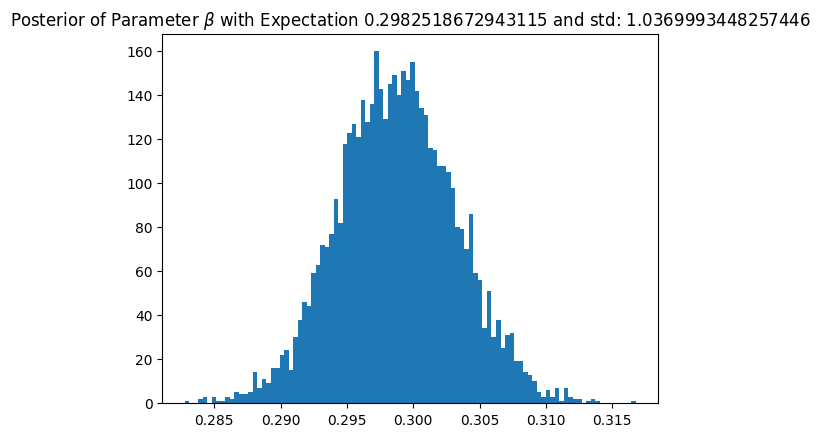

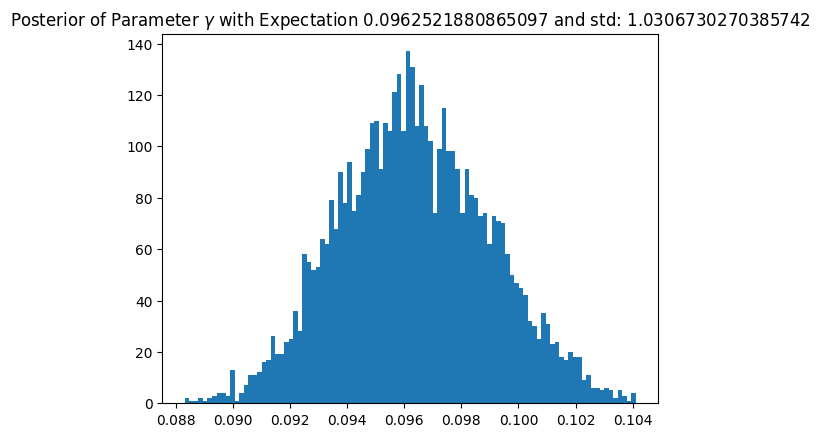

In [ ]:
burn_in = 100
plt.title(f"Posterior of Parameter $\\beta$ with Expectation {jnp.exp(jnp.mean(samples[:,0]))} and std: {jnp.exp(jnp.std(samples[:,0]))}")
plt.hist(jnp.exp(samples[burn_in:,0]),bins = 100)
plt.show()

plt.title(f"Posterior of Parameter $\\gamma$ with Expectation {jnp.exp(jnp.mean(samples[:,1]))} and std: {jnp.exp(jnp.std(samples[:,1]))}")
plt.hist(jnp.exp(samples[burn_in:,1]),bins = 100)
plt.show()